<p style="border: 1px solid #e7692c; border-left: 15px solid #e7692c; padding: 10px; text-align:justify;">
    <strong style="color: #e7692c">Tip.</strong> <a style="color: #000000;" href="https://nbviewer.jupyter.org/github/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/blob/master/Chapter07/ch7_nb6_apply_dann_to_train_segmentation_model_on_synthetic_data.ipynb" title="View with Jupyter Online">Click here to view this notebook on <code>nbviewer.jupyter.org</code></a>. 
    <br/>These notebooks are better read there, as Github default viewer ignores some of the formatting and interactive content.
    </p>

<table style="font-size: 1em; padding: 0; margin: 0;">
    <tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #363636; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #e7692c;">Hands-on</span> Computer Vision with TensorFlow 2</span><br/>by <em>Eliot Andres</em> & <em>Benjamin Planche</em> (Packt Pub.)</strong><br/><br/>
        <strong>> Chapter 7: Training on Complex and Scarce Datasets</strong><br/>
    </p>

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #e7692c;">
    Notebook 6:</small><br/>Applying DANN to the Training of a Segmentation Model on Synthetic Data</h1>
<br/>
<p style="border-left: 15px solid #363636; text-align:justify; padding: 0 10px;">
    We detailed and implemented the <strong>Domain Adversarial Neural Network (<em>DANN</em>)</strong> solution in the previous Notebook <a href="./ch7_nb5_train_a_simple_domain_adversarial_network_(dann).ipynb">7-5</a>. DANN is a great example of unsupervised domain adaptation, proposed to help training models when one has only access to unlabeled target data and labeled but different-looking training samples.<br/><br/>
    In this notebook, we will apply our <em>DANN</em> to the training of our semantic segmentation model, given the scenario presented in Notebook <a href="./ch7_nb4_train_segmentation_model_on_synthetic_images.ipynb">7-4</a>, hopefully to improve a bit its poor performance caused by the *realism gap* between the synthetic training images and the target real ones.
</p>
<br/>
<p style="border-left: 15px solid #e7692c; padding: 0 10px; text-align:justify;">
    <strong style="color: #e7692c;">Tip.</strong> The notebooks shared on this git repository illustrate some notions from the book "<em><strong>Hands-on Computer Vision with TensorFlow 2</strong></em>" written by Eliot Andres and Benjamin Planche, published by Packt. If you enjoyed the insights shared here, <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!"><strong>please consider acquiring the book!</strong></a>
<br/><br/>
The book provides further guidance for those eager to learn about computer vision and to harness the power of TensorFlow 2 and Keras to build efficient recognition systems for object detection, segmentation, video processing, smartphone applications, and more.</p>
        </td>
        <td style="vertical-align: top; padding: 0; margin: 0; width: 280px;">
    <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!" target="_blank">
        <img src="../banner_images/book_cover.png" width=280>
    </a>
    <p style="background: #e7692c; color:#ffffff; padding: 10px; text-align:justify;"><strong>Leverage deep learning to create powerful image processing apps with TensorFlow 2 and Keras. <br/></strong>Get the book for more insights!</p>
    <ul style="height: 32px; white-space: nowrap; text-align: center; margin: 0px; padding: 0px; padding-top: 10px;">
    <li style="display: block;height: 100%;float: left;vertical-align: middle;margin: 0 25px 10px;padding: 0px;">
        <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Get the book on Amazon (paperback or Kindle version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_amazon.png" width="75px">
        </a>
    </li>
    <li style="display: inline-block;height: 100%;vertical-align: middle;float: right;margin: -5px 25px 10px;padding: 0px;">
        <a href="https://www.packtpub.com/application-development/hands-computer-vision-tensorflow-2" title="Get your Packt book (paperback, PDF, ePUB, or MOBI version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_packt.png" width="75px">
        </a>
    </li>
    </ul>
        </td>
        </tr>
        </table>

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## Preparing the Source and Target Data

As done in Notebook [7-4](./ch7_nb4_train_segmentation_model_on_synthetic_images.ipynb), we first define the input pipelines for our use-case.

### Setting Up the Target Input Pipeline (*Cityscapes*)

In our current scenario, we are assuming that some real training images are available, but not their labels. Therefore, we not only fetch and prepare the *Cityscapes*[$^1$](#ref) validation dataset, but we also instantiate an input pipeline to serve the training *Cityscapes* images without their labels:

In [2]:
import math
from plot_utils import plot_image_grid
from cityscapes_utils import (
    CITYSCAPES_FOLDER, # change this variable to Cityscapes root folder
    CITYSCAPES_LABELS, CITYSCAPES_IGNORE_VALUE, get_cityscapes_file_pairs,
    cityscapes_input_fn, segmentation_input_fn, postprocess_to_show)

# Key variables:
batch_size      = 8
num_epochs      = 90
image_size      = [512, 512]
num_channels    = 3
num_classes     = len(CITYSCAPES_LABELS)
random_seed     = 1
num_show        = 3

half_batch_size = batch_size // 2 

In [3]:
cityscapes_train_input_files, _ = get_cityscapes_file_pairs(split='train')
cityscapes_val_input_files, cityscapes_val_gt_files = get_cityscapes_file_pairs(split='val')
num_cityscapes_train_imgs = len(cityscapes_train_input_files)
num_cityscapes_val_imgs = len(cityscapes_val_input_files)
print("Cityscapes - Training Dataset   : {} images (no GT).".format(num_cityscapes_train_imgs))
print("Cityscapes - Validation Dataset : {} image/GT pairs.".format(num_cityscapes_val_imgs))

val_steps_per_epoch = math.ceil(num_cityscapes_val_imgs / batch_size)

cityscapes_train_dataset = segmentation_input_fn(
    cityscapes_train_input_files, None, 
    resize_to=image_size, batch_size=half_batch_size,
    shuffle=True, num_epochs=num_epochs, augment=True, seed=random_seed)

cityscapes_val_dataset = segmentation_input_fn(
    cityscapes_val_input_files, cityscapes_val_gt_files, 
    resize_to=image_size, batch_size=batch_size,
    shuffle=True, num_epochs=None, augment=False, seed=random_seed)

# For visualization purpose, we also create a validation dataset using the images 
# with blurred faces/immatriculation plates (for privacy). As we will just use 
# 2-3 images, we only create the `tf.data.Dataset` to grab one batch:
visual_val_dataset = cityscapes_input_fn(
    root_folder=CITYSCAPES_FOLDER, resize_to=image_size, batch_size=num_show,
    shuffle=True, num_epochs=1, augment=False, seed=random_seed, blurred=True)

val_image_samples, val_gt_samples = next(visual_val_dataset.__iter__())
del visual_val_dataset

Cityscapes - Training Dataset   : 2975 images (no GT).
Cityscapes - Validation Dataset : 500 image/GT pairs.


### Setting Up the Source  Input Pipeline (*SYNTHIA*)

Reusing the methods presented Notebook [7-4](./ch7_nb4_train_segmentation_model_on_synthetic_images.ipynb) (and assuming the dataset formatting detailed there has been performed already), we set up our training input pipeline, serving samples from the *SYNTHIA* dataset[$^2$](#ref):

In [4]:
from synthia_utils import get_synthia_file_pairs

synthia_train_input_files, synthia_train_gt_files = get_synthia_file_pairs(gt_type='LABEL_CS')
num_synthia_train_imgs = len(synthia_train_input_files)
print("Synthia - Training Dataset   : {} image/GT pairs.".format(num_synthia_train_imgs))
train_steps_per_epoch = math.ceil(len(synthia_train_input_files) / batch_size)

synthia_train_dataset = segmentation_input_fn(
    synthia_train_input_files, synthia_train_gt_files, 
    resize_to=image_size, batch_size=half_batch_size,
    shuffle=True, num_epochs=num_epochs, augment=True, seed=random_seed)

Synthia - Training Dataset   : 7288 image/GT pairs.


## Preparing the Recognition and Domain Adaptation Models

In this section, we will first instantiate the model we want to teach how to perform semantic segmentation. In a second time, we will set up the _DANN_ domain adaptation scheme to guide the training of our main model.

### Defining the Recognition Model

To compare with the previous results we obtain, we reuse the same **_FCN-8s_** model [$^3$](#ref) to perform semantic segmentation.

As done in Notebook [7-5](./ch7_nb5_train_a_simple_domain_adversarial_network_(dann).ipynb), in order to keep track of the actual output of our model, we save the name given to it:

In [5]:
from fcn import fcn_8s

fcn8s_segmentation_model = fcn_8s(image_size, num_channels, num_classes)
# Name of semantic segmentation last layer:
segmentation_head_name = fcn8s_segmentation_model.output.name.split('/')[0]
print('Name of semantic segmentation last layer: {}'.format(segmentation_head_name))

Name of semantic segmentation last layer: predictions


### Appending the DANN Method

We now wrap our model with the **_DANN_** solution[$^{4,5}$](#ref) before starting the training.

#### DANN Domain Classification Sub-Network

First, we append the domain classification sub-network to out model, after its feature extractor. To that end, we re-define here the gradient reversal layer implemented in Notebook [7-5](./ch7_nb5_train_a_simple_domain_adversarial_network_(dann).ipynb): 

In [9]:
@tf.custom_gradient
def reverse_gradient(x, hp_lambda):
    """
    Flips the sign of the incoming gradient during backpropagation.
    :param x:         Input tensor
    :param hp_lambda: Hyper-parameter lambda (c.f. DANN paper), i.e. an updatable 
                      coefficient applied to the reversed gradient
    :return:          Input tensor with reverse gradient (+ function to compute this reversed gradient)
    """
    
    # Feed-forward operation:
    y = tf.identity(x)
    
    # Back-propagation/gradient-computing operation:
    def _flip_gradient(dy):
        # Since the decorated function `reverse_gradient()` actually has 2 inputs 
        # (counting `hp_lambda), we have to return the gradient for each -- but
        # anyway, the derivative w.r.t `hp_lambda` is null:
        return tf.math.negative(dy) * hp_lambda, tf.constant(0.)
    
    return y, _flip_gradient


class GradientReversal(tf.keras.layers.Layer):
    '''Flip the sign of gradient during training.'''

    def __init__(self, hp_lambda, **kwargs):
        super().__init__(**kwargs)
        self.hp_lambda = hp_lambda

    def call(self, inputs, training=None):
        return reverse_gradient(inputs, self.hp_lambda)

    def get_config(self):
        config = super().get_config()
        config['hp_lambda'] = self.hp_lambda
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [10]:
# Note: Find below a draft for a more advanced implementation of this layer.

# class GradientReversal(tf.keras.layers.Layer):
#     """Layer flipping the gradient sign during training."""
# 
#     def __init__(self, hp_lambda, num_training_steps, training_step=0, **kwargs):
#         """
#         Initialize the layer.
#         :param hp_lambda:           Initial value of the reversal rate.
#         :param num_training_steps:  Estimated max. number of training steps, to decay
#                                     `hp_lambda` accordingly.
#         :param training_step:       Initial training step.
#         :param kwargs:              Opt. parameters (e.g., `name`).
#         """
#         super().__init__(**kwargs)
#         self.hp_lambda = tf.Variable(
#             hp_lambda, dtype=tf.float32, name="lambda", trainable=False)
#         self.training_step = tf.Variable(
#             training_step, dtype=tf.int32, name="training_step", trainable=False)
#         self.num_training_steps = num_training_steps
# 
# 
#     def _adapt_rate(self, training):
#         """
#         Adapt the reversal rate and number of training steps.
#         :param training:  Flag for training steps.
#         """
#         p = tf.clip_by_value(self.training_step / self.num_training_steps, 0., 1.)
#         l = 2. / (1. + tf.math.exp(-10. * p)) - 1
#         lr = 0.01 / (1. + 10 * p)**0.75
#         
#         self.hp_lambda.assign(tf.cast(lr, self.hp_lambda.dtype))
#         self.training_step.assign_add(tf.cast(training, tf.int32))
#         
#         
#     def call(self, inputs, training=None):
#         """
#         Perform the layer's operation.
#         :param inputs:    Input tensor.
#         :param training:  Flag for training steps.
#         :return:          Tensor with flipped/scaled gradient.
#         """
#         if training is None:
#             training = tf.keras.backend.learning_phase()
#             
#         self._adapt_rate(training)
#         return reverse_gradient(inputs, self.hp_lambda)
# 
#     def get_config(self):
#         """ Get the layer's config."""
#         config = super().get_config()
#         config['hp_lambda'] = self.hp_lambda.numpy()
#         config['num_training_steps'] = self.num_training_steps
#         config['training_step'] = self.training_step.numpy()
#         return config
# 
#     @classmethod
#     def from_config(cls, config):
#         """ Initialize the layer from its config."""
#         return cls(**config)

We can now add the domain classification head to our model:

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dropout, GlobalMaxPool2D, Dense

# We build a network head for domain classification:
num_classes = 2 # i.e., synt or real
domain_preds_head_name = 'domain_predictions'
f5 = fcn8s_segmentation_model.get_layer('block5_pool').output

grad_rev = GradientReversal(1.)(f5)#, train_steps_per_epoch * num_epochs)(f5)

conv1 = Conv2D(filters=256, kernel_size=3, padding='same',
                  activation='relu')(grad_rev)
drop1 = Dropout(0.5)(conv1)
conv2 = Conv2D(filters=64, kernel_size=3, padding='same',
                  activation='relu')(drop1)
drop2 = Dropout(0.5)(conv2)
conv3 = Conv2D(filters=32, kernel_size=1, padding='same',
                  activation='relu')(drop2)
maxpool = GlobalMaxPool2D()(conv3)
dense1 = Dense(32, activation='relu')(maxpool)
dense2 = Dense(16, activation='relu')(dense1)
dense3 = Dense(num_classes, activation=None, name=domain_preds_head_name)(dense2)

domain_classification_model = Model(fcn8s_segmentation_model.input, dense3)
combined_model = Model(fcn8s_segmentation_model.input, 
                       (fcn8s_segmentation_model.output, dense3))
domain_classification_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0   

#### Preparing Data Inputs for DANN Training

To train our _DANN_-extended model, we need to feed it with:

- Source input data (i.e., the _SYNTHIA_ images)
- Source label data (i.e., the _SYNTHIA_ label maps)
- Target input data (i.e., the _Cityscapes_ images)
- Domain label data (i.e., generated class labels for each training image: `1` for the _source_ images and `0` for _target_ ones)

To adapt our input training pipeline accordingly, we reuse the methods implemented in the previous notebook (refer to it for details):

In [12]:
def _prepare_data_for_dann_training(source_data, target_images,
                                    main_head_name='main_preds', domain_head_name='domain_preds'):
    
    source_images, source_labels = source_data
    
    # We check the number of samples for each domains (to cover edge cases, i.e., 
    # for the possibly smaller batch at the end of each epoch):
    num_source = tf.shape(source_images)[0]
    num_target = tf.shape(target_images)[0]
    
    # Full image batch:
    batch_images = tf.concat((source_images, target_images), axis=0)
    
    # Semantic segmentation label maps:
    # By default, the loss will be computed over the full batch, but we do not have GT
    # label maps for the target images. A simplistic solution is as follows:
    # 1) We create dummy GT label maps for the target images:
    target_labels = tf.zeros([num_target, *source_labels.shape[1:]], dtype=source_labels.dtype)
    batch_labels  = tf.concat((source_labels, target_labels), axis=0)
    # 2) We tell TF/Keras **not** to penalize the model for its predictions on the target
    # images/dummy labels, by assigning a weight = 0 to these elements of the batch:
    source_weight_per_sample = tf.tile([1], [num_source])
    target_weight_per_sample = tf.tile([0], [num_target])
    batch_sample_weights = tf.concat((source_weight_per_sample, target_weight_per_sample), 
                                     axis=0)
    
    # Note: this solution is simple but not optimal. Layer and loss operations will be applied
    # to half the batch even though the results won't be used for backpropagation. A better
    # solution to avoid useless computations would be to implement a custom loss aware it
    # should ignore the 2nd half of the batch. Or even better: to edit the model so that
    # only the source images are feed-forwarded to the classification head (e.g., adding a custom
    # layers dropping ~half the batch).
    
    # Domain classification ground-truth labels:
    # if we assign the label "1" to source data and "0" to target data, then we can simply reuse
    # the `batch_sample_weights` tensor:
    domain_labels = batch_sample_weights
    domain_sample_weights = tf.tile([1], [num_source + num_target])
    
    batch_targets = {main_head_name: batch_labels, 
                     domain_head_name: domain_labels}
    batch_sample_weights = {main_head_name: batch_sample_weights, 
                            domain_head_name: domain_sample_weights}

    return batch_images, batch_targets, batch_sample_weights


def _prepare_data_for_dann_validation(target_images, target_labels,
                                      main_head_name='main_preds', domain_head_name='domain_preds'):
    # The batch contains only validation/test images from the target domain. 
    # This time, we want to evaluate the main loss over these images, so we assign a normal loss
    # weight = 1 to each samples.
    num_samples = tf.shape(target_images)[0]
    
    # We want to evaluate over 
    loss_weights = tf.tile([1], [num_samples])
    
    domain_labels = tf.tile([0], [num_samples])
    
    batch_targets = {main_head_name: target_labels, 
                     domain_head_name: domain_labels}
    batch_sample_weights = {main_head_name: loss_weights, 
                            domain_head_name: loss_weights}

    return target_images, batch_targets, batch_sample_weights

We can now define the input pipelines accordingly:

In [13]:
import functools

# Combined training dataset:
training_dataset = tf.data.Dataset.zip((synthia_train_dataset, cityscapes_train_dataset))

prepare_for_dann_fn = functools.partial(_prepare_data_for_dann_training,
                                        main_head_name=segmentation_head_name, 
                                        domain_head_name=domain_preds_head_name)

training_dataset = training_dataset.map(prepare_for_dann_fn, num_parallel_calls=4)

print(training_dataset)

<ParallelMapDataset shapes: ((None, 512, 512, 3), {predictions: (None, 512, 512, 1), domain_predictions: (None,)}, {predictions: (None,), domain_predictions: (None,)}), types: (tf.float32, {predictions: tf.int32, domain_predictions: tf.int32}, {predictions: tf.int32, domain_predictions: tf.int32})>


In [14]:
prepare_for_dann_fn = functools.partial(_prepare_data_for_dann_validation,
                                        main_head_name=segmentation_head_name, 
                                        domain_head_name=domain_preds_head_name)

testing_dataset = cityscapes_val_dataset.map(prepare_for_dann_fn, num_parallel_calls=4)
print(testing_dataset)

<ParallelMapDataset shapes: ((None, 512, 512, 3), {predictions: (None, 512, 512, 1), domain_predictions: (None,)}, {predictions: (None,), domain_predictions: (None,)}), types: (tf.float32, {predictions: tf.int32, domain_predictions: tf.int32}, {predictions: tf.int32, domain_predictions: tf.int32})>


In [15]:
options = tf.data.Options()
options.experimental_optimization.map_and_batch_fusion = True
options.experimental_optimization.map_fusion = True
options.experimental_optimization.map_parallelization = True
# options.experimental_optimization.map_vectorization = True
options.experimental_optimization.noop_elimination = True
options.experimental_optimization.apply_default_optimizations = True
options.experimental_autotune = True

training_dataset = training_dataset.with_options(options)
testing_dataset = testing_dataset.with_options(options)

## Training and Testing the Model

With the combined model and its input pipelines ready, we can now proceed with the training.

### Training Setup

Reusing the utility methods for semantic segmentation that we implemented in previous notebooks, we define the main loss and combine the combined model:

In [16]:
from tf_losses_and_metrics import SegmentationAccuracy, SegmentationMeanIoU

optimizer = tf.keras.optimizers.Adam()

# Class weights computed in previous chapter:
cityscapes_class_weights = [0.95, 2.84, 1.53, 5.07, 4.74, 4.38, 6.18, 5.19, 1.86, 
                            4.48, 3.37, 4.31, 6.48, 2.64, 5.86, 5.97, 5.98, 6.86, 5.45]
cityscapes_class_weights = tf.constant(cityscapes_class_weights)

In [18]:
from tf_losses_and_metrics import prepare_class_weight_map, prepare_data_for_segmentation_loss
    

class WeightedSegmentationLossWithSampleWeights(tf.losses.SparseCategoricalCrossentropy):
    def __init__(self, ignore_value=CITYSCAPES_IGNORE_VALUE, weights=None,
                 from_logits=False, reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE, 
                 name='loss'):
        super().__init__(from_logits=from_logits, reduction=reduction, name=name)
        self.ignore_value = ignore_value
        self.num_classes = num_classes
        self.weights = weights
    
    def _prepare_data(self, y_true, y_pred):
        num_classes = y_pred.shape[-1]
        y_true, y_pred = prepare_data_for_segmentation_loss(
            y_true, y_pred, num_classes=num_classes, ignore_value=self.ignore_value)
        return y_true, y_pred
    
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), tf.shape(self.weights)[0])
        y_weight = tf.tensordot(y_true_one_hot, self.weights, axes=1)
        y_weight = tf.reduce_max(y_weight, axis=-1, name="class_weight_labels")
        if sample_weight is not None:
            sample_weight = tf.expand_dims(
                tf.expand_dims(sample_weight, axis=-1), axis=-1)
            
            y_weight = tf.math.multiply(y_weight, 
                                        tf.broadcast_to(sample_weight, tf.shape(y_weight)))
            
        return super().__call__(y_true, y_pred, sample_weight=y_weight)
    
    def call(self, y_true, y_pred):
        is_loss_nan = tf.equal(y_true, self.ignore_value)
        y_true = tf.where(is_loss_nan, tf.zeros_like(y_true), y_true)
        loss = super().call(y_true, y_pred)
        loss = tf.where(tf.squeeze(is_loss_nan, axis=-1), tf.zeros_like(loss), loss)
        
        return loss
 

combined_model.compile(
    optimizer=optimizer, 
    loss={
        # Loss for main model:
        segmentation_head_name: WeightedSegmentationLossWithSampleWeights(
            from_logits=True, weights=cityscapes_class_weights),
        # Loss for the domain classification head:
        domain_preds_head_name: tf.losses.SparseCategoricalCrossentropy(from_logits=True)},
    loss_weights={
        segmentation_head_name: 1.0, 
        domain_preds_head_name: 0.0001}, # reduce to 0.0001 for 1st epochs if model diverges
    metrics={
        segmentation_head_name: [SegmentationAccuracy(), SegmentationMeanIoU(num_classes)],
        domain_preds_head_name: tf.metrics.SparseCategoricalAccuracy(name='acc')})

In [19]:
import collections
from keras_custom_callbacks import SimpleLogCallback, TensorBoardImageGridCallback

model_name = 'cityscapes_fcn8s_dann'
model_dir = os.path.join('models', model_name)

def postprocess_for_grid_callback(input_images, predicted_results, gt_images):
    
    # Our network has two heads, so the prediction parameter is a list of their results:
    predicted_images, predicted_domains = predicted_results
    
    # We convert the predicted logits into categorical results
    # (i.e for each pixel, we assign the class corresponding to the largest logit/probability):
    predicted_images = tf.math.argmax(predicted_images, axis=-1)
    predicted_images = tf.expand_dims(predicted_images, axis=-1)

    # Then we post-process the tensors for display:
    images_show, predicted_show, gt_show = postprocess_to_show(
        input_images, predicted_images, gt_images, one_hot=True)

    return images_show, predicted_show, gt_show

# Callback to postprocess some validation results and display them in Tensorboard:
callback_tb_grid = TensorBoardImageGridCallback(
    log_dir=model_dir, 
    input_images=val_image_samples, target_images=val_gt_samples, 
    preprocess_fn=postprocess_for_grid_callback,
    tag=model_name + '_results', figsize=(15, 15))

# Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1):
# Note: we will display only a subset of the metrics, to keep the logs concise:
metrics_to_print = collections.OrderedDict([
    ("loss", "loss"), 
    # ("s-loss", segmentation_head_name + "_loss"),
    # ("d-loss", domain_preds_head_name + "_loss"), 
    # ("s-acc", segmentation_head_name + "_acc"),
    # ("s-IoU", segmentation_head_name + "_mIoU"),
    ("d-acc", domain_preds_head_name + "_acc"),
    ("val-d-acc", "val_" + domain_preds_head_name + "_acc"),
    ("val-s-acc", "val_" + segmentation_head_name + "_acc"),
    ("val-s-IoU", "val_" + segmentation_head_name + "_mIoU"),
    # ("target d-acc", "val_" + domain_preds_head_name + "_acc")
])

callback_simple_log = SimpleLogCallback(metrics_to_print, num_epochs=num_epochs)

<Figure size 4500x4500 with 0 Axes>

### Training Loop

***Note:*** As mentioned in previous notebooks, this training is compute-heavy (large model and dataset). Make sure the procedure is performed on GPU(s) -- refer to Chapter 2 for alternatives.

In [20]:
callbacks = [
    # Callback to interrupt the training if the validation loss stops improving:
    tf.keras.callbacks.EarlyStopping(patience=8, monitor="val_" + segmentation_head_name + "_acc",
                                     restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model  specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), period=5),
    # Callback to print compacted metrics at the end of each epoch:
    callback_simple_log,
    # Callback to log some validation results as image grids into TensorBoard:
    callback_tb_grid
]

history = combined_model.fit(
    training_dataset, epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=testing_dataset, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=callbacks)

Training: start.
Epoch  0/90: loss = 1.125; d-acc = 0.592; val-d-acc = 1.000; val-s-acc = 0.480; val-s-IoU = 0.263
Epoch  1/90: loss = 0.626; d-acc = 0.767; val-d-acc = 0.936; val-s-acc = 0.456; val-s-IoU = 0.268
Epoch  2/90: loss = 0.464; d-acc = 0.896; val-d-acc = 0.982; val-s-acc = 0.453; val-s-IoU = 0.269
Epoch  3/90: loss = 0.368; d-acc = 0.936; val-d-acc = 1.000; val-s-acc = 0.399; val-s-IoU = 0.264
Epoch  4/90: loss = 0.316; d-acc = 0.959; val-d-acc = 0.974; val-s-acc = 0.556; val-s-IoU = 0.274
Epoch  5/90: loss = 0.294; d-acc = 0.965; val-d-acc = 1.000; val-s-acc = 0.558; val-s-IoU = 0.272
Epoch  6/90: loss = 0.269; d-acc = 0.972; val-d-acc = 1.000; val-s-acc = 0.448; val-s-IoU = 0.268
Epoch  7/90: loss = 0.273; d-acc = 0.973; val-d-acc = 1.000; val-s-acc = 0.585; val-s-IoU = 0.271
Epoch  8/90: loss = 0.249; d-acc = 0.982; val-d-acc = 0.996; val-s-acc = 0.545; val-s-IoU = 0.269
Epoch  9/90: loss = 0.219; d-acc = 0.989; val-d-acc = 1.000; val-s-acc = 0.424; val-s-IoU = 0.269
Epo

### Analysis of the Results

From the logs above, we can already observe an accuracy boost on the test data compared to the results obtained in Notebook [7.4](./ch7_nb4_train_segmentation_model_on_synthetic_images.ipynb) with the model simply trained on synthetic data. Even though the labels of the real images were not available, preventing us for directly training our model on these samples, _DANN_ allowed us to leverage this information on the target domain in an unsupervised manner.

***Note:*** We can also observe that, despite the gradient reversal scheme, the domain classification head still managed to distinguish between real and synthetic images. This can be due to the too large *realism gap* between the two domains, or due to a too simple architecture for this sub-network.

Let us have a look at some segmentation results, on synthetic training data and real test ones: 

/home/benjamin/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


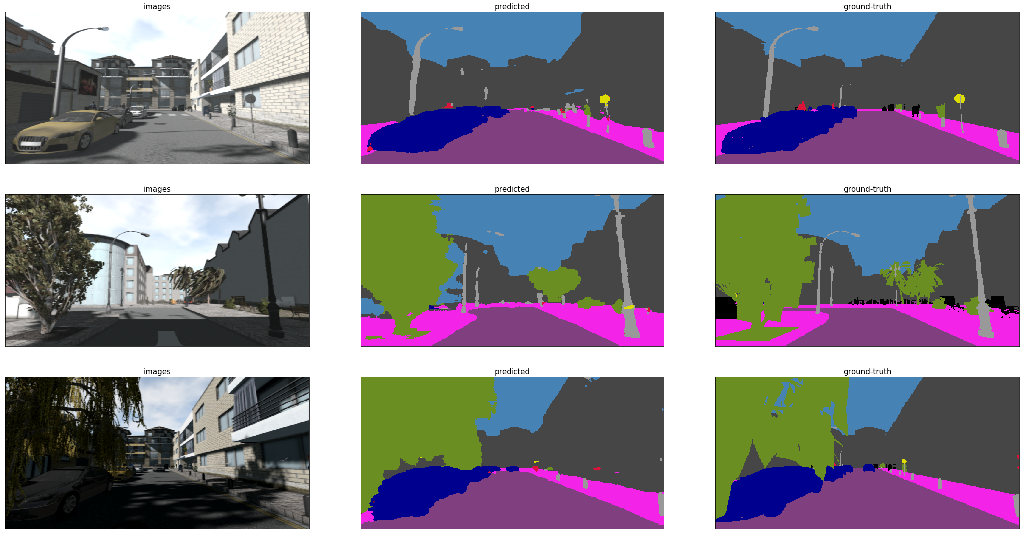

In [21]:
train_image_samples, train_gt_samples = next(synthia_train_dataset.__iter__())
train_image_samples, train_gt_samples = train_image_samples[:num_show], train_gt_samples[:num_show]

train_pred_samples = combined_model.predict(train_image_samples)

image_show, predicted_show, gt_show = postprocess_for_grid_callback(
    train_image_samples, train_pred_samples, train_gt_samples)

figure = plot_image_grid([image_show.numpy(), predicted_show.numpy(), gt_show.numpy()], 
                         titles=["images", "predicted", "ground-truth"])
figure.show()

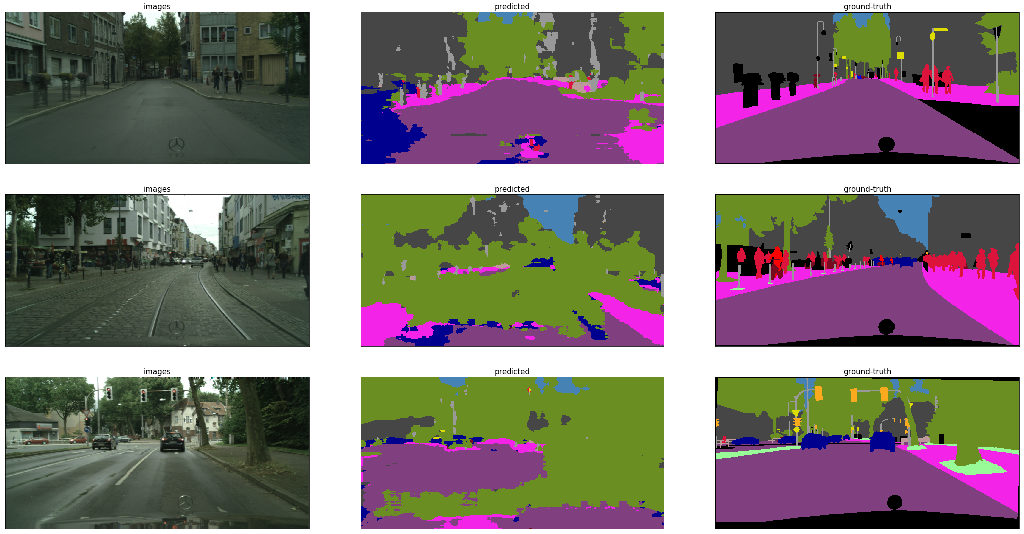

In [22]:
val_pred_samples = combined_model.predict(val_image_samples)

image_show, predicted_show, gt_show = postprocess_for_grid_callback(
    val_image_samples, val_pred_samples, val_gt_samples)

figure = plot_image_grid([image_show.numpy(), predicted_show.numpy(), gt_show.numpy()], 
                         titles=["images", "predicted", "ground-truth"])
figure.show()

## Conclusion

Though we still cannot match the performance of models trained on real, relevant, data, applying this domain adaptation scheme provided a significant accuracy boost. The results could be further improved by taking into account other techniques presented along the book (e.g., transfer learning), by adopting more advanced domain adaptation methods (c.f. Chapter 7), by using synthetic data closer to the target ones, etc.

<a id="ref"></a>
#### References

1. Cordts, M., Omran, M., Ramos, S., Rehfeld, T., Enzweiler, M., Benenson, R., Franke, U., Roth, S., Schiele, B., 2016. The Cityscapes Dataset for Semantic Urban Scene Understanding. In: 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR). Presented at the 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), IEEE, Las Vegas, NV, USA, pp. 3213–3223.
2. Ros, G., Sellart, L., Materzynska, J., Vazquez, D. and Lopez, A.M., 2016. The synthia dataset: A large collection of synthetic images for semantic segmentation of urban scenes. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 3234-3243).
3. Shelhamer, E., Long, J., Darrell, T., 2017. Fully Convolutional Networks for Semantic Segmentation. IEEE Transactions on Pattern Analysis and Machine Intelligence 39, 640–651.
4. Ajakan, H., Germain, P., Larochelle, H., Laviolette, F. and Marchand, M., 2014. Domain-adversarial neural networks. arXiv preprint arXiv:1412.4446.
5. Ganin, Y., Ustinova, E., Ajakan, H., Germain, P., Larochelle, H., Laviolette, F., Marchand, M. and Lempitsky, V., 2016. Domain-adversarial training of neural networks. The Journal of Machine Learning Research, 17(1), pp.2096-2030.